# Pruning

In [1]:
import sys
sys.path.append("..")

In [2]:
from asyncio import MultiLoopChildWatcher
from doctest import OutputChecker

from turtle import hideturtle
import warnings

from models import GeneralModel
from models.statistics.Metrics import Metrics
from utils.config_utils import *
from utils.model_utils import *
from utils.system_utils import *

import matplotlib.pyplot as plt
from models.networks.ConvertMLP import ConvertMLP2,ConvertMLP3

from verify_utils.verify_utils import verify_single_image

warnings.filterwarnings("ignore")

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


In [3]:
torch.__version__

'1.11.0+cu113'

In [4]:
# define arguments manually
arguments = argparse.Namespace()
# device
arguments.device = "cuda"

# define arguments for model
#arguments.model = "ResNet18" # ResNet not supported for structured
arguments.model = "MLP2"
arguments.hidden_dim = 64
#arguments.input_dim = None # for ResNet
#arguments.input_dim = (1,1,1) # for LeNet5
arguments.input_dim = (28,28) # for MNIST
arguments.output_dim = 10
arguments.disable_masking = 1 # 0 for disable mask, 1 for mask (unstructured)
arguments.track_weights = 0
arguments.enable_rewinding = 0
arguments.growing_rate = 0.0000
arguments.outer_layer_pruning = 0
# arguments.prune_criterion = "SNIPit"  # unstructured

arguments.prune_criterion = "SNAPit" # or SNAPit ... # structured
arguments.l0 = 0
arguments.l0_reg = 1.0
arguments.l1_reg = 0
arguments.lp_reg = 0
arguments.l2_reg = 5e-5
arguments.hoyer_reg = 0.001
arguments.N = 6000 # different for different dataset
arguments.beta_ema = 0.999


# define arguments for criterion
arguments.pruning_limit = 0.5
arguments.snip_steps = 6

# not pre-trained model
arguments.checkpoint_name = None
arguments.checkpoint_model = None

# dataset
arguments.data_set = "MNIST"
arguments.batch_size = 512
arguments.mean = (0.1307,)
arguments.std = (0.3081,)
arguments.tuning = 0
arguments.preload_all_data = 0
arguments.random_shuffle_labels = 0

# loss
arguments.loss = "CrossEntropy"

# optimizer
arguments.optimizer = "ADAM"
arguments.learning_rate = 2e-3

# training
arguments.save_freq = 1e6
arguments.eval = 0
arguments.train_scheme = "DefaultTrainer"
arguments.seed = 1234
arguments.epochs = 5

arguments.grad_noise = 0
arguments.grad_clip =10
arguments.eval_freq = 1000
arguments.max_training_minutes= 6120
arguments.plot_weights_freq = 50
arguments.prune_delay = 0
arguments.prune_freq = 1
arguments.rewind_to = 6

arguments.skip_first_plot = 0
arguments.disable_histograms = 0
arguments.disable_saliency = 0
arguments.disable_confusion = 0
arguments.disable_weightplot = 0
arguments.disable_netplot = 0
arguments.disable_activations = 0

arguments.pruning_rate = 0
# during training
arguments.pruning_freq = 1

In [5]:
metrics = Metrics()
out = metrics.log_line
print = out

ensure_current_directory()
global out 
out = metrics.log_line
out(f"starting at {get_date_stamp()}")

metrics._batch_size = arguments.batch_size
metrics._eval_freq = arguments.eval_freq

starting at 2022-04-28_17.51.09


In [6]:
device = configure_device(arguments)

In [7]:
# get model
model: GeneralModel = find_right_model(
        NETWORKS_DIR,arguments.model,
        device=device,
        hidden_dim = arguments.hidden_dim,
        input_dim = arguments.input_dim,
        output_dim = arguments.output_dim,
        is_maskable=arguments.disable_masking,
        is_tracking_weights=arguments.track_weights,
        is_rewindable=arguments.enable_rewinding,
        is_growable=arguments.growing_rate > 0,
        outer_layer_pruning=arguments.outer_layer_pruning,
        maintain_outer_mask_anyway=(
                                       not arguments.outer_layer_pruning) and (
                                           "Structured" in arguments.prune_criterion),
        l0=arguments.l0,
        l0_reg=arguments.l0_reg,
        N=arguments.N,
        beta_ema=arguments.beta_ema,
        l2_reg=arguments.l2_reg
    ).to(device)

In [8]:
for key,param in model.named_parameters():
    print(param.size())

torch.Size([64, 784])
torch.Size([64])
torch.Size([10, 64])
torch.Size([10])


In [9]:
# get criterion
criterion = find_right_model(
        CRITERION_DIR,arguments.prune_criterion,
        model=model,
        limit=arguments.pruning_limit,
        start=0.5,
        steps=arguments.snip_steps,
        device=arguments.device
    )   

In [10]:
def load_checkpoint(arguments, metrics, model):
    if (not (arguments.checkpoint_name is None)) and (not (arguments.checkpoint_model is None)):
        path = os.path.join(RESULTS_DIR, arguments.checkpoint_name, MODELS_DIR, arguments.checkpoint_model)
        state = DATA_MANAGER.load_python_obj(path)
        try:
            model.load_state_dict(state)
        except KeyError as e:
            print(list(state.keys()))
            raise e
        out(f"Loaded checkpoint {arguments.checkpoint_name} from {arguments.checkpoint_model}")

# load pre-trained weights if specified
load_checkpoint(arguments, metrics, model)  

In [11]:
# load data
train_loader, test_loader = find_right_model(
        DATASETS, arguments.data_set,
        arguments=arguments,
        mean=arguments.mean,
        std=arguments.std
    )

Using mean (0.1307,)


In [12]:
# get loss function
loss = find_right_model(
        LOSS_DIR, arguments.loss,
        device=device,
        l1_reg=arguments.l1_reg,
        lp_reg=arguments.lp_reg,
        l0_reg=arguments.l0_reg,
        hoyer_reg=arguments.hoyer_reg
    )

In [13]:
# get optimizer
optimizer = find_right_model(
        OPTIMS, arguments.optimizer,
        params=model.parameters(),
        lr=arguments.learning_rate,
        weight_decay=arguments.l2_reg if not arguments.l0 else 0
    )


In [14]:
if not arguments.eval:
    # build trainer
    run_name = f'_model={arguments.model}_dataset={arguments.data_set}_prune-criterion={arguments.prune_criterion}' + \
               f'_pruning-limit={arguments.pruning_limit}_train-scheme={arguments.train_scheme}_seed={arguments.seed}'
    trainer = find_right_model(
            TRAINERS_DIR, arguments.train_scheme,
            model=model,
            loss=loss,
            optimizer=optimizer,
            device=device,
            arguments=arguments,
            train_loader=train_loader,
            test_loader=test_loader,
            metrics=metrics,
            criterion=criterion,
            run_name = run_name
        )

Made datestamp: 2022-04-28_17.51.14_model=MLP2_dataset=MNIST_prune-criterion=SNAPit_pruning-limit=0.5_train-scheme=DefaultTrainer_seed=1234


In [15]:
trainer.train()

Started training
Saved results/2022-04-28_17.51.14_model=MLP2_dataset=MNIST_prune-criterion=SNAPit_pruning-limit=0.5_train-scheme=DefaultTrainer_seed=1234/output/scores
pruning 25088 percentage 0.5 length_nonzero 50176
pruning 320 percentage 0.5 length_nonzero 640
  (layers): Sequential(
    (0): ContainerLinear(in_features=784, out_features=32.0, bias=True)
    (2): ContainerLinear(in_features=32.0, out_features=10, bias=True)
final percentage after snap: 0.5
Saved results/2022-04-28_17.51.14_model=MLP2_dataset=MNIST_prune-criterion=SNAPit_pruning-limit=0.5_train-scheme=DefaultTrainer_seed=1234/output/scores
pruning 784 percentage 0.03125 length_nonzero 25088
pruning 10 percentage 0.03125 length_nonzero 320
  (layers): Sequential(
    (0): ContainerLinear(in_features=784, out_features=31.0, bias=True)
    (2): ContainerLinear(in_features=31.0, out_features=10, bias=True)
final percentage after snap: 0.03125
Saved results/2022-04-28_17.51.14_model=MLP2_dataset=MNIST_prune-criterion=SNA

<Figure size 432x288 with 0 Axes>

In [16]:
for key,param in model.named_parameters():
    print(param.size())

torch.Size([31, 784])
torch.Size([31])
torch.Size([10, 31])
torch.Size([10])


# Quantization

In [30]:
# change to cpu and eval mode
model.to("cpu").eval()

# get the model parameters
state = model.state_dict()
# convet the model to a quantizable model
q_model= ConvertMLP2(model)
# load previous parameter
q_model.load_state_dict(state)
# set quantization config
q_model.qconfig = torch.quantization.get_default_qconfig('fbgemm')
# fuse_model
q_model.fuse

<bound method ConvertMLP2.fuse of ConvertMLP2(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=31, bias=True)
    (1): ReLU()
    (2): Linear(in_features=31, out_features=10, bias=True)
  )
  (quant): QuantStub()
  (dequant): DeQuantStub()
)>

In [31]:
# use calibrate date to calibrate model
model_prepared = torch.quantization.prepare(q_model)
cali_data,label=next(iter(train_loader))
model_prepared(cali_data)

tensor([[ -2.3108,  -9.7951,   0.0323,  ...,  -3.1140,  -0.2278,   2.6842],
        [ -4.2946,  -1.7511,   3.1539,  ..., -12.1547,   2.3074,  -6.1053],
        [ -5.1860,  -4.1389,   0.5035,  ...,  -2.7515,   7.0176,  -1.4935],
        ...,
        [ -6.9084,  -9.5606,  -0.4408,  ...,  -8.0227,   5.7194,   0.6637],
        [  9.1948,  -9.9583,   3.2057,  ...,  -0.8465,  -0.0597,  -1.1003],
        [ -1.7863, -11.0944,   1.8253,  ...,   1.1026,  -0.5046,   0.8225]],
       grad_fn=<AddmmBackward0>)

In [32]:
# convert to int8
model_int8 = torch.quantization.convert(model_prepared)

In [33]:
model_int8

ConvertMLP2(
  (layers): Sequential(
    (0): QuantizedLinear(in_features=784, out_features=31, scale=0.38516145944595337, zero_point=69, qscheme=torch.per_channel_affine)
    (1): ReLU()
    (2): QuantizedLinear(in_features=31, out_features=10, scale=0.3201819658279419, zero_point=68, qscheme=torch.per_channel_affine)
  )
  (quant): Quantize(scale=tensor([0.0255]), zero_point=tensor([16]), dtype=torch.quint8)
  (dequant): DeQuantize()
)

In [34]:
# compare the model size
def print_size_of_model(model, label=""):
    torch.save(model.state_dict(), "temp.p")
    size=os.path.getsize("temp.p")
    print("model: ",label,' \t','Size (KB):', size/1e3)
    os.remove('temp.p')
    return size

In [35]:
size_model_fp32 = print_size_of_model(model,label="fp32model")
size_model_int8 = print_size_of_model(model_int8,label="quantized")


model:  fp32model  	 Size (KB): 100.127
model:  quantized  	 Size (KB): 29.691


# how to verify a quantized model ?

In [54]:
# get a test image 
images,label=next(iter(test_loader))
img = images[0]
    

In [55]:
# first convert the input to int
int_input=model_int8.quant(img).int_repr().view(-1,1)


In [74]:
#weight_int = model_int8.layers[0]._packed_params._weight_bias()[0].int_repr()

In [84]:
weight_int=model_int8.layers[0].weight().int_repr()

In [73]:
weight,bias=model_int8.layers[0]._packed_params._weight_bias()
scale=model_int8.layers[0].scale
zero_point = model_int8.layers[0].zero_point
print(scale,zero_point)

0.38516145944595337 69


In [92]:
_packed_params = torch.ops.quantized.linear_prepack(weight, bias)
torch.ops.quantized.linear(int_input, _packed_params, scale, zero_point)

NotImplementedError: Could not run 'quantized::linear' with arguments from the 'CPU' backend. This could be because the operator doesn't exist for this backend, or was omitted during the selective/custom build process (if using custom build). If you are a Facebook employee using PyTorch on mobile, please visit https://fburl.com/ptmfixes for possible resolutions. 'quantized::linear' is only available for these backends: [QuantizedCPU, BackendSelect, Python, Named, Conjugate, Negative, ZeroTensor, ADInplaceOrView, AutogradOther, AutogradCPU, AutogradCUDA, AutogradXLA, AutogradLazy, AutogradXPU, AutogradMLC, AutogradHPU, Tracer, AutocastCPU, Autocast, Batched, VmapMode, Functionalize].

QuantizedCPU: registered at ../aten/src/ATen/native/quantized/cpu/qlinear.cpp:455 [kernel]
BackendSelect: fallthrough registered at ../aten/src/ATen/core/BackendSelectFallbackKernel.cpp:3 [backend fallback]
Python: registered at ../aten/src/ATen/core/PythonFallbackKernel.cpp:47 [backend fallback]
Named: registered at ../aten/src/ATen/core/NamedRegistrations.cpp:7 [backend fallback]
Conjugate: registered at ../aten/src/ATen/ConjugateFallback.cpp:18 [backend fallback]
Negative: registered at ../aten/src/ATen/native/NegateFallback.cpp:18 [backend fallback]
ZeroTensor: registered at ../aten/src/ATen/ZeroTensorFallback.cpp:86 [backend fallback]
ADInplaceOrView: fallthrough registered at ../aten/src/ATen/core/VariableFallbackKernel.cpp:64 [backend fallback]
AutogradOther: fallthrough registered at ../aten/src/ATen/core/VariableFallbackKernel.cpp:35 [backend fallback]
AutogradCPU: fallthrough registered at ../aten/src/ATen/core/VariableFallbackKernel.cpp:39 [backend fallback]
AutogradCUDA: fallthrough registered at ../aten/src/ATen/core/VariableFallbackKernel.cpp:47 [backend fallback]
AutogradXLA: fallthrough registered at ../aten/src/ATen/core/VariableFallbackKernel.cpp:51 [backend fallback]
AutogradLazy: fallthrough registered at ../aten/src/ATen/core/VariableFallbackKernel.cpp:55 [backend fallback]
AutogradXPU: fallthrough registered at ../aten/src/ATen/core/VariableFallbackKernel.cpp:43 [backend fallback]
AutogradMLC: fallthrough registered at ../aten/src/ATen/core/VariableFallbackKernel.cpp:59 [backend fallback]
AutogradHPU: fallthrough registered at ../aten/src/ATen/core/VariableFallbackKernel.cpp:68 [backend fallback]
Tracer: registered at ../torch/csrc/autograd/TraceTypeManual.cpp:293 [backend fallback]
AutocastCPU: fallthrough registered at ../aten/src/ATen/autocast_mode.cpp:461 [backend fallback]
Autocast: fallthrough registered at ../aten/src/ATen/autocast_mode.cpp:305 [backend fallback]
Batched: registered at ../aten/src/ATen/BatchingRegistrations.cpp:1059 [backend fallback]
VmapMode: fallthrough registered at ../aten/src/ATen/VmapModeRegistrations.cpp:33 [backend fallback]
Functionalize: registered at ../aten/src/ATen/FunctionalizeFallbackKernel.cpp:52 [backend fallback]


In [71]:
params=[]
names=[]
for name,module in model_int8.named_modules():
    names.append(name)
    if "params" in name:
        params.append(module)
names

['',
 'layers',
 'layers.0',
 'layers.0._packed_params',
 'layers.1',
 'layers.2',
 'layers.2._packed_params',
 'quant',
 'dequant']

In [61]:
weight_tuple=params[0]._weight_bias()
weight_tuple[0]

tensor([[-0.1145, -0.0442, -0.0409,  ..., -0.0785, -0.0376, -0.0703],
        [-0.0074,  0.0321,  0.0296,  ..., -0.0395, -0.0444,  0.0469],
        [ 0.0062, -0.0348,  0.0232,  ..., -0.0366,  0.0473,  0.0205],
        ...,
        [-0.0715, -0.0447,  0.0179,  ...,  0.0067, -0.0335, -0.0737],
        [-0.0607,  0.0000, -0.0214,  ..., -0.0464, -0.0161, -0.0607],
        [ 0.0200,  0.0360, -0.0380,  ..., -0.0400,  0.0140,  0.0200]],
       size=(31, 784), dtype=torch.qint8,
       quantization_scheme=torch.per_channel_affine,
       scale=tensor([0.0016, 0.0025, 0.0009, 0.0027, 0.0016, 0.0018, 0.0016, 0.0016, 0.0019,
        0.0025, 0.0016, 0.0015, 0.0009, 0.0023, 0.0011, 0.0020, 0.0022, 0.0020,
        0.0019, 0.0011, 0.0017, 0.0018, 0.0028, 0.0017, 0.0017, 0.0017, 0.0019,
        0.0020, 0.0022, 0.0018, 0.0020], dtype=torch.float64),
       zero_point=tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0]),
       axis=0)

In [ ]:
# calculate the first layer
# get the 

# Verify

## test single image verify

In [21]:
img,label=next(iter(test_loader))
img_test = img[3].squeeze().to(device)
model.to(device)
img,label,indicator=verify_single_image(model=model,image=img_test,eps=0.2)
if indicator==0:
    print("verified!")


found solution


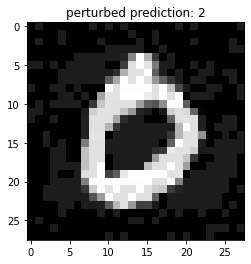

In [22]:
plt.imshow(img.value.reshape(28, 28), cmap='gray')
plt.title(f"perturbed prediction: {label.value.argmax()}")
plt.show()

## multi-processing to get robustness accuracy

In [24]:
from verify_utils.verify_utils import verify_batch_images
import time

## compare time without multi-processing

In [26]:
# a seririalized implementation
start = time.time()
img_number=0
verified_number=0
imgs,labels=next(iter(test_loader))
eps = 0.01
model.to(device)
img_number += len(imgs)
for img in imgs:
    img = img.squeeze().to(device)
    _,_,indicator = verify_single_image(model=model,image=img,eps=eps)
    if indicator==0:
        verified_number+=1
finish=time.time()
print(f"accuracy:{verified_number/img_number}")
print(f"time elapsed {finish-start}s")
    


found solution
found solution
found solution
found solution
found solution
found solution
found solution
found solution
found solution
found solution
found solution
found solution
found solution
found solution
found solution
found solution
found solution
accuracy:0.966796875
time elapsed 962.2611734867096s


In [30]:
print(f"total_num:{img_number},verified_num:{verified_number}")

total_num:512,verified_num:495


In [27]:
from multiprocessing import Process, Value,Lock
import time
from verify_utils.verify_utils import verify_batch_images

In [33]:
# multi processing
start = time.time()
# step1 get a batch images
imgs,labels=next(iter(test_loader))
model.to(device)
# start from a GPU model and tensor imgs
# step2 get the labels for a batch imgs
labels=model(imgs.to(device)).argmax(axis=1).cpu().numpy()
# step 3 split imgs and labels for each process
num_process =10
processes=[]
num_per_process=int(len(imgs)/num_process)
# convert model to cpu
model.to("cpu")
# define processes
lock =Lock()
total_num = Value('i',0)
verified_num = Value('i',0)
eps=0.01
for i in range(num_process):
    if i!=num_process-1:
        process_imgs=imgs[num_per_process*i:num_per_process*(i+1)].squeeze()
        process_labels = labels[num_per_process*i:num_per_process*(i+1)]
    else:
        process_imgs=imgs[num_per_process*i:].squeeze()
        process_labels = labels[num_per_process*i:]
    p=Process(target=verify_batch_images,args=(model,process_imgs,process_labels,eps,total_num,verified_num,lock))
    processes.append(p)
    
# start
for p in processes:
    p.start()
    
# join
for p in processes:
    p.join()
finish = time.time()

print(f"total_num:{total_num.value},verified_num:{verified_num.value}")
print(f"accuracy:{verified_num.value/total_num.value}")
print(f"time elapsed {finish-start}s")

found solution
found solution
found solution
found solution
found solution
found solution
found solution
found solution
found solution
found solution
found solution
found solution
found solution
found solution
found solution
found solution
found solution
total_num:512,verified_num:495
accuracy:0.966796875
time elapsed 547.378613948822s


In [ ]:
# 2  cpu 526.1203780174255s
# 4  cpu 534.806479215622s
# 10 cpu 548.1252098083496s 547.378613948822s